In [44]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [46]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [49]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', cache=True)
mnist.target = mnist.target.astype(np.int8) 
sort_by_target(mnist) 

In [50]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [51]:
y.shape

(70000,)

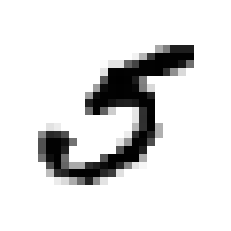

In [52]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
interpolation="nearest")
plt.axis("off")
plt.show()

In [55]:
y[36000]

5

In [56]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [57]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [58]:
y_train = y_train.astype(np.int8)
y_test = y_test.astype(np.int8)

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [59]:
#Training a Binary Classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [60]:
sgd_clf.predict([some_digit])

array([ True])

In [64]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96815
0.92615
0.96185


In [66]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9613, 0.9635, 0.9661])

In [67]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [72]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

In [74]:
#Confusion Matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [75]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54122,   457],
       [ 1725,  3696]])

In [82]:
#When it claims an image represents a 5, it is correct only 88.9% of the time. Moreover, it
#only detects 68% of the 5s
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8899590657356128

In [83]:
recall_score(y_train_5, y_train_pred)

0.6817930271167681

In [84]:
#The F 1 score is the harmonic mean of precision and recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7720910800083559

In [87]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([5220.50278623])

In [90]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [91]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [92]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

In [94]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [95]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

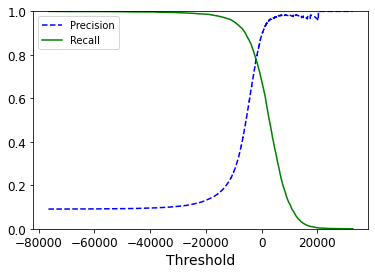

In [96]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [102]:
y_train_pred_90 = (y_scores > 0)

In [103]:
precision_score(y_train_5, y_train_pred_90)

0.8899590657356128

In [104]:
recall_score(y_train_5, y_train_pred_90)

0.6817930271167681

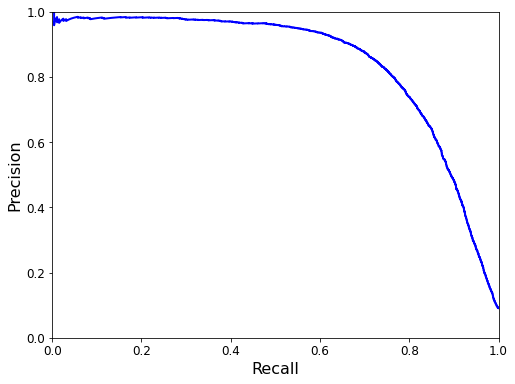

In [116]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [107]:
#The receiver operating characteristic (ROC) curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

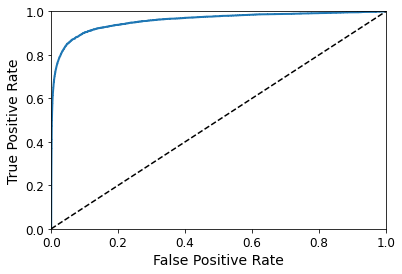

In [108]:
plot_roc_curve(fpr, tpr)
plt.show()

In [112]:
#AUC - area under curve
#you should prefer the PR curve whenever the positive class is rare or
#when you care more about the false positives than the false negatives, and the ROC curve otherwise
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9577210519742373